<div align="center" style="font-size:24px;"><b>End-to-End &beta;-Variational Autoencoder (VAE) for MNIST Dataset</b></div>

This notebook presents a comprehensive analysis and implementation of a $\beta$-Variational Autoencoder (VAE) using the MNIST dataset in the Keras framework. It covers everything from data loading and preprocessing to model training and evaluation.


## Table of Contents
1. [Library Imports](#Library-Imports)
2. [Data Loading and Preprocessing](#Data-Loading-and-Preprocessing)
3. [Model Architecture](#Model-Architecture)
4. [Training the Model](#Training-the-Model)
5. [Evaluation and Results](#Evaluation-and-Results)
6. [Conclusion](#Conclusion)


<a id="Library Imports"></a>
## Library Imports

In [ ]:
#!pip install seaborn
#!pip install tensorflow

In [20]:
# Data Handling and Numerical Libraries
import numpy as np                          # Handling large data arrays
import matplotlib.pyplot as plt             # Creating visualizations
from matplotlib.colors import ListedColormap
import seaborn as sns                       # Advanced data visualization
import random

# Keras - Deep Learning API
import keras                                # High-level neural networks API
from keras.datasets import mnist            # MNIST dataset of hand-written digits
from keras.layers import (                  # Neural network layers
    Conv2D, Conv2DTranspose, 
    Input, Flatten, Dense, 
    Lambda, Reshape
)
from keras.models import Model              # Model definition and training
from keras.callbacks import (               # Training callbacks
    EarlyStopping, ModelCheckpoint
)
from keras import backend as K  
from sklearn.manifold import TSNE            

<a id="Data Loading and Preprocessing"></a>
## Data Loading and Preprocessing

In [14]:
# Loading the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train and x_test are arrays of image data, and y_train and y_test are arrays of digit labels (0-9).

11490434/11490434 [==============================] - 2s 0us/step


Before diving into the preprocessing steps, it's crucial to understand the format and type of data we're dealing with. Let's examine the data type and shape of the `x_train` dataset:

In [15]:
print(f"Data Type: {x_train.dtype}")
print(f"Shape: {x_train.shape}")

Data Type: uint8
Shape: (60000, 28, 28)


**Note:** 

If `print(x_train.dtype)` outputs `uint8`, it means that the elements in the `x_train` array are of the type "unsigned 8-bit integer". In practical terms, a `uint8` data type can represent integers ranging from $0$ to $255$ (inclusive). This is a common format for image data where the intensity of each color channel (red, green, blue) in each pixel is represented as an integer from $0$ (no intensity) to $255$ (maximum intensity).

So, if `x_train` is coming from an image dataset like MNIST, each element of `x_train` is an integer between $0$ and $255$ representing the grayscale intensity of a pixel in an image.

Neural networks usually perform better with floating-point numbers, and work better with data in a normalized form, i.e., in the range of $0-1$. Converting the data type to 'float32' allows us to perform this normalization.


In [16]:
# Normalize the images to [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [17]:
# Check again the type of elements in x_train after formatting.
print(f"Data Type: {x_train.dtype}")

Data Type: float32


In [18]:
# Retrieving the number of images and their dimensions from the train set
img_num_train = x_train.shape[0]
img_width     = x_train.shape[1]
img_height    = x_train.shape[2]

# Displaying the train set information
print(f"The MNIST train set contains {img_num_train} images, each with dimensions:"
      f"\n(width x height) = ({img_width} x {img_height}) pixels.")

# Retrieving the number of images from the test set
img_num_test  = x_test.shape[0]

# Displaying the test set information
print(f"The MNIST test set also contains {img_num_test} images with the same dimensions as the train set.")

The MNIST train set contains 60000 images, each with dimensions:
(width x height) = (28 x 28) pixels.
The MNIST test set also contains 10000 images with the same dimensions as the train set.


**Reshaping Image Data for Convolutional Neural Network Input**

**Note**: In machine learning libraries like Keras, images need to be formatted in a specific shape (height, width, channels). The term "channels" refers to the number of color channels in the image. For grayscale images like those in the MNIST dataset, there is only one channel. Therefore, we need to reshape our image data to fit this format.

In [19]:
# Define the number of channels: 1 for grayscale images
num_channels = 1

# Reshape the training and test datasets to include the channel dimension
x_train = x_train.reshape(img_num_train, img_height, img_width, num_channels)
x_test = x_test.reshape(img_num_test, img_height, img_width, num_channels)

# Define the input dimensions for the CNN
input_dimensions = (img_height, img_width, num_channels)

# Display the reshaped dimensions
print(f"Dimensions of each image for the model: (img_height, img_width, num_channels) = {input_dimensions}.")
print(f"Reshaped training data shape: {x_train.shape}")

Dimensions of each image for the model: (img_height, img_width, num_channels) = (28, 28, 1).
Reshaped training data shape: (60000, 28, 28, 1)


In [ ]:
num_channels = 1

# Reshaping the training and test datasets to have a 4D tensor representing the number of channels
x_train = x_train.reshape(img_num_train, img_height, img_width, num_channels)
x_test  = x_test .reshape(img_num_test , img_height, img_width, num_channels)

# Defining the shape of the input data which will be used to configure the neural network
input_dimensions = (img_height, img_width, num_channels)

print(f"Dimensions of each image that will be fed into the model are"
      f"\n(img_height, img_width, num_channels)={input_dimensions}.")
print(x_train.shape)

Dimensions of each image that will be fed into the model are
(img_height, img_width, num_channels)=(28, 28, 1).
(60000, 28, 28, 1)


**Visualizing the data to see a few arbitrary images**

In [21]:
def visualize_samples(data, sample_indices, figsize=(5, 5)):
    """
    Visualizes a set of images from the provided dataset.

    :param data: The dataset containing the images.
    :param sample_indices: A list of indices for the images to be visualized.
    :param figsize: Size of the figure for the plots.
    """
    plt.figure(figsize=figsize)

    for i, img_index in enumerate(sample_indices):
        plt.subplot(2, 2, i + 1)
        plt.imshow(data[img_index][:, :, 0], cmap='gray')
        plt.title(f'Image index: {img_index}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

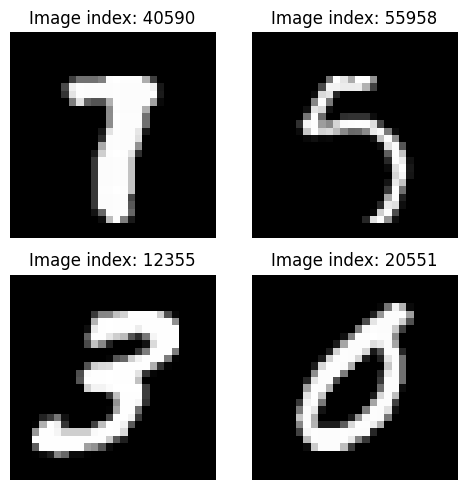

In [22]:
# Randomly sample indices
random_indices = random.sample(range(len(x_train)), 4)

# Visualize the sampled images
visualize_samples(x_train, random_indices)

<a id="Model Architecture"></a>
## Model Architecture


In this section, we will outline the architecture of our Variational Autoencoder (VAE). The VAE model is composed of three main components: 

1. **Encoder:** The encoder's role is to take the input data and compress it into a latent (hidden) space, effectively reducing its dimensionality and capturing the essential features of the data.

2. **Latent Space:** The latent space represents the compressed representation of the input data. Here, we model the data distribution that we aim to generate from.

3. **Decoder:** The decoder part of the VAE takes the representation in the latent space and reconstructs the original input data from this compressed form.

This structure allows the VAE not only to generate new data similar to the input data but also to learn a meaningful and efficient representation of the input data in the latent space. Let's start by detailing the encoder part of our VAE.


### Encoder Architecture

The encoder is a crucial component of the VAE that compresses the input data into a latent space. It consists of several layers, each with specific functions:

1. **Input Layer:** Captures the shape of the input data.
2. **Convolution Layers:** Extracts features from the input.
3. **Flattening Layer:** Transforms the output of the convolution layers into a 1D tensor.
4. **Dense Layer:** Further processes the features.
5. **Output Layer:** Prepares for transition to the latent space.

Note that the latent dimension represents the number of dimensions in the space to which the encoder compresses the input.
Here, I choose a dimensionality of 10, aligning with the number of unique digits (0-9) in the MNIST dataset.
This choice can facilitate learning digit-specific features in each dimension but may require adjustment based on specific model performance and goals.

In [24]:
latent_space_dim = 10

In [25]:
# Input Layer
# Defines the shape of the input data for the encoder.
encoder_input_layer = Input(shape=input_dimensions, name='encoder_input_layer')

In [26]:
# Convolution Layers
# Applies convolution operations to extract features from the input image.
encoder_layer = Conv2D(32, 3, padding='same', activation='relu')(encoder_input_layer)
encoder_layer = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(encoder_layer)
encoder_layer = Conv2D(64, 3, padding='same', activation='relu')(encoder_layer)
encoder_layer = Conv2D(64, 3, padding='same', activation='relu')(encoder_layer)

# Note on Strides:
# Strides define the step size of the filter as it moves across the image. Here, a stride of 2 reduces the spatial dimensions of the output.

In [27]:
# Flattening Layer
# Converts the 3D output of convolution layers into a 1D tensor for dense layers.
encoder_layer = Flatten()(encoder_layer)

In [28]:
# Dense Layer
# A fully connected layer that combines extracted features and performs further learning.
encoder_layer = Dense(32, activation='relu')(encoder_layer)

In [29]:
# Output Layer for Encoder
# Prepares the encoded data for transition into the latent space, approximating a probability distribution.
mu_layer = Dense(latent_space_dim, name='latent_mu')(encoder_layer)
sigma_layer = Dense(latent_space_dim, name='latent_sigma')(encoder_layer)

# Storing the output shape for use in the decoder
encoder_output_shape = K.int_shape(encoder_layer)
print(f"Output shape of encoder: {encoder_output_shape}")

Output shape of encoder: (None, 32)


**Important Note on the VAE's Goal:**
The Variational Autoencoder aims not just to encode and decode input but to encode it into a representation that approximates a specified probability distribution (typically normal). The parameters of this distribution (mean and standard deviation) are learned by the model and used to generate encoded representations.

### Latent Space and Reparameterization Trick

The reparameterization trick is a fundamental concept in training Variational Autoencoders. It allows us to backpropagate through random sampling processes, which are inherently non-differentiable. 

- **The Challenge:** Directly sampling from the Gaussian distribution defined by $\mu$ (mean) and $\sigma$ (standard deviation) is non-differentiable, posing a challenge for backpropagation.
- **The Solution:** We sample from a standard normal distribution and transform this sample using $\mu$ and $\sigma$. The transformed sample $z = \mu + \sigma * \epsilon$ (where $\epsilon$ is the random sample) is differentiable with respect to $\mu$ and $\sigma$.


In [31]:
### Implementing the Reparameterization Trick
def sample_z(args):
    """
    Generate a sample from the Gaussian distribution defined by args=(mu, sigma).
    
    Args:
    mu_layer:    The mean of the Gaussian distribution.
    sigma_layer: The log standard deviation of the Gaussian distribution.

    Returns:
    A sample from the Gaussian distribution.
    """
    mu_layer, sigma_layer = args
    batch_size = K.shape(mu_layer)[0]
    dim = K.int_shape(mu_layer)[1]

    # Generate a random sample from a standard normal distribution with the same shape
    epsilon = K.random_normal(shape=(batch_size, dim))

    # Scale and shift the sample by mu and sigma
    return mu_layer + K.exp(sigma_layer / 2) * epsilon


In [32]:
# Creating the 'z' layer using the Lambda layer to apply the reparameterization trick
z = Lambda(sample_z, output_shape=(latent_space_dim,), name='z')([mu_layer, sigma_layer])

# Note on Lambda Layer:
# The Lambda layer in Keras allows us to apply arbitrary expressions that are differentiable.

In [34]:
# Building the encoder model
encoder_model = Model(encoder_input_layer, [mu_layer, sigma_layer, z], name='encoder_model')

# Save the model for future use
encoder_model.save('/Volumes/D/GitHub-Portfolio/DeepLearning-MNIST-VAE/models/encoder_model_MNIST.h5')

# Display the model summary
print(encoder_model.summary())

Model: "encoder_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input_layer (Input  [(None, 28, 28, 1)]          0         []                            
 Layer)                                                                                           
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 32)           320       ['encoder_input_layer[0][0]'] 
                                                                                                  
 conv2d_1 (Conv2D)           (None, 14, 14, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 14, 14, 64)           36928     ['conv2d_1[0][0]']

/Users/mahdihabibi/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [52]:
print(encoder_model.summary())

Model: "encoder_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input_layer (Input  [(None, 28, 28, 1)]          0         []                            
 Layer)                                                                                           
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 32)           320       ['encoder_input_layer[0][0]'] 
                                                                                                  
 conv2d_1 (Conv2D)           (None, 14, 14, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 14, 14, 64)           36928     ['conv2d_1[0][0]']

### Decoder Architecture

The decoder is the component of the VAE that reconstructs the data from the latent space representation. It mirrors the encoder in reverse, progressively upscaling the compressed data back to its original dimension. The decoder consists of the following key steps:

1. **Input Layer:** Starts with the latent space representation.
2. **Dense and Reshape Layers:** Upscales the compressed data to a higher dimension suitable for convolutional operations.
3. **Deconvolutional (Conv2DTranspose) Layers:** Further upscales and refines the data to reconstruct the original input.

In [35]:
# Decoder Input Layer
decoder_input_layer = Input(shape=(latent_space_dim,), name='decoder_input_layer')

In [38]:
# Initial Dense Layer
# The number of units is derived from the last convolutional layer of the encoder
num_units = 14 * 14 * 64
decoder_dense_layer = Dense(num_units, activation='relu')(decoder_input_layer)

# Reshaping Layer
# The dense layer's output is reshaped to match the last convolutional layer's output shape in the encoder
reshape_dims = (14, 14, 64)
decoder_reshape_layer = Reshape(reshape_dims)(decoder_dense_layer)

In [39]:
# Deconvolution / Upsampling Layers
upsample_layer_config = {'filters': 32,
                         'kernel_size': 3,
                         'padding': 'same',
                         'activation': 'relu',
                         'strides': (2, 2)
                         }
decoder_upsample_layer = Conv2DTranspose(**upsample_layer_config)(decoder_reshape_layer)

In [40]:
# Final Layer of Decoder
decoder_output_config = {'filters': num_channels,
                         'kernel_size': 3,
                         'padding': 'same',
                         'activation': 'sigmoid',
                         'name': 'decoder_output'
                         }
decoder_output_layer = Conv2DTranspose(**decoder_output_config)(decoder_upsample_layer)

In [41]:
# Building the Decoder Model
decoder_model = Model(decoder_input_layer, decoder_output_layer, name='decoder_model')
decoder_model.save('/Volumes/D/GitHub-Portfolio/DeepLearning-MNIST-VAE/models/decoder_model_MNIST.h5')

In [42]:
decoder_model.summary()

Model: "decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input_layer (Input  [(None, 10)]              0         
 Layer)                                                          
                                                                 
 dense_2 (Dense)             (None, 12544)             137984    
                                                                 
 reshape (Reshape)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 28, 28, 32)        18464     
 anspose)                                                        
                                                                 
 decoder_output (Conv2DTran  (None, 28, 28, 1)         289       
 spose)                                                          
                                                     

In [43]:
# Reconstructed Output from Decoder
reconstructed_output = decoder_model(z)

print(f"The type  of 'reconstructed_output' is: {type(reconstructed_output)}")
print(f"The shape of 'reconstructed_output' is: {reconstructed_output.shape}")

The type  of 'reconstructed_output' is: <class 'keras.src.engine.keras_tensor.KerasTensor'>
The shape of 'reconstructed_output' is: (None, 28, 28, 1)


### VAE Loss Function
The loss function for a VAE is a combination of reconstruction loss and the KL divergence. The reconstruction loss ensures the decoded samples resemble the original inputs, while the KL divergence loss ensures the latent space distribution approximates a normal distribution.

In [44]:
class VAELossLayer(keras.layers.Layer):
    """
    Custom Keras layer that calculates the loss (reconstruction + KL divergence)
    of the Variational AutoEncoder (VAE)
    """

    def calculate_loss(self, original_input, reconstructed_output, mu, sigma):
        """
        Calculates VAE loss, which is the sum of the reconstruction loss and KL-divergence loss
        """
        original_input  = K.flatten(original_input)
        reconstructed_output = K.flatten(reconstructed_output)

        # Reconstruction loss - binary crossentropy is used as the final layer uses sigmoid activation
        reconstruction_loss = keras.metrics.binary_crossentropy(original_input, reconstructed_output)

        # KL divergence loss - acts as a regularizer- beta is changable
        #kl_loss = -0.5 * K.mean(1 + sigma - K.square(mu) - K.exp(sigma), axis=-1)
        #kl_loss = beta * K.mean(-0.5 * (1 + sigma - K.square(mu) - K.exp(sigma)), axis=-1)
        kl_loss = -5e-4 * K.mean(1 + sigma - K.square(mu) - K.exp(sigma), axis=-1)

        return K.mean(reconstruction_loss + kl_loss)

    def call(self, inputs):
        """
        Computes the loss and adds it to the layer's losses
        """
        original_input = inputs[0]
        reconstructed_output = inputs[1]
        mu = inputs[2]
        sigma = inputs[3]

        loss = self.calculate_loss(original_input, reconstructed_output, mu, sigma)
        self.add_loss(loss, inputs = inputs)

        # Returns the original layer inputs
        return original_input

In [45]:
# Adding the loss computation layer to the model
vae_loss_output = VAELossLayer()([encoder_input_layer, reconstructed_output, mu_layer, sigma_layer])

print(f"The type of 'vae_loss_output' is: {type(vae_loss_output)}")
print(f"The shape of 'vae_loss_output' is: {vae_loss_output.shape}")

The type of 'vae_loss_output' is: <class 'keras.src.engine.keras_tensor.KerasTensor'>
The shape of 'vae_loss_output' is: (None, 28, 28, 1)


In [48]:
# Final VAE Model
final_vae_model = Model(encoder_input_layer, vae_loss_output, name='vae_model')
final_vae_model.save('/Volumes/D/GitHub-Portfolio/DeepLearning-MNIST-VAE/models/final_vae_model_MNIST.h5')

In [51]:
# Compile the final VAE model
# The optimizer is set to 'adam', and the loss is already defined within the model
final_vae_model.compile(optimizer='adam', loss=None)

# Displaying the summary of the final VAE model
print(final_vae_model.summary())

Model: "vae_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input_layer (Input  [(None, 28, 28, 1)]          0         []                            
 Layer)                                                                                           
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 32)           320       ['encoder_input_layer[0][0]'] 
                                                                                                  
 conv2d_1 (Conv2D)           (None, 14, 14, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 14, 14, 64)           36928     ['conv2d_1[0][0]']    

<a id="Training the Model"></a>
## Training the Model


In [53]:
# Training the Variational Autoencoder with Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5),
    ModelCheckpoint('/Volumes/D/GitHub-Portfolio/DeepLearning-MNIST-VAE/models/best_model.h5', monitor='val_loss', save_best_only=True)
]

# Fitting the model to the data
history = final_vae_model.fit(
    x_train, None, 
    epochs=10, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=callbacks
)

Epoch 1/10
1500/1500 [==============================] - 31s 20ms/step - loss: 0.1694 - val_loss: 0.1289
Epoch 2/10
1500/1500 [==============================] - 33s 22ms/step - loss: 0.1236 - val_loss: 0.1206
Epoch 3/10
1500/1500 [==============================] - 34s 23ms/step - loss: 0.1180 - val_loss: 0.1177
Epoch 4/10
1500/1500 [==============================] - 36s 24ms/step - loss: 0.1150 - val_loss: 0.1153
Epoch 5/10
1500/1500 [==============================] - 35s 23ms/step - loss: 0.1129 - val_loss: 0.1135
Epoch 6/10
1500/1500 [==============================] - 36s 24ms/step - loss: 0.1113 - val_loss: 0.1125
Epoch 7/10
1500/1500 [==============================] - 35s 23ms/step - loss: 0.1100 - val_loss: 0.1110
Epoch 8/10
1500/1500 [==============================] - 35s 23ms/step - loss: 0.1081 - val_loss: 0.1094
Epoch 9/10
1500/1500 [==============================] - 36s 24ms/step - loss: 0.1064 - val_loss: 0.1082
Epoch 10/10
1500/1500 [==============================] - 35s 24m

<a id="Evaluation and Results"></a>
## Evaluation and Results


### Visualization of original and reconstructed images

1/1 [==============================] - 0s 9ms/step


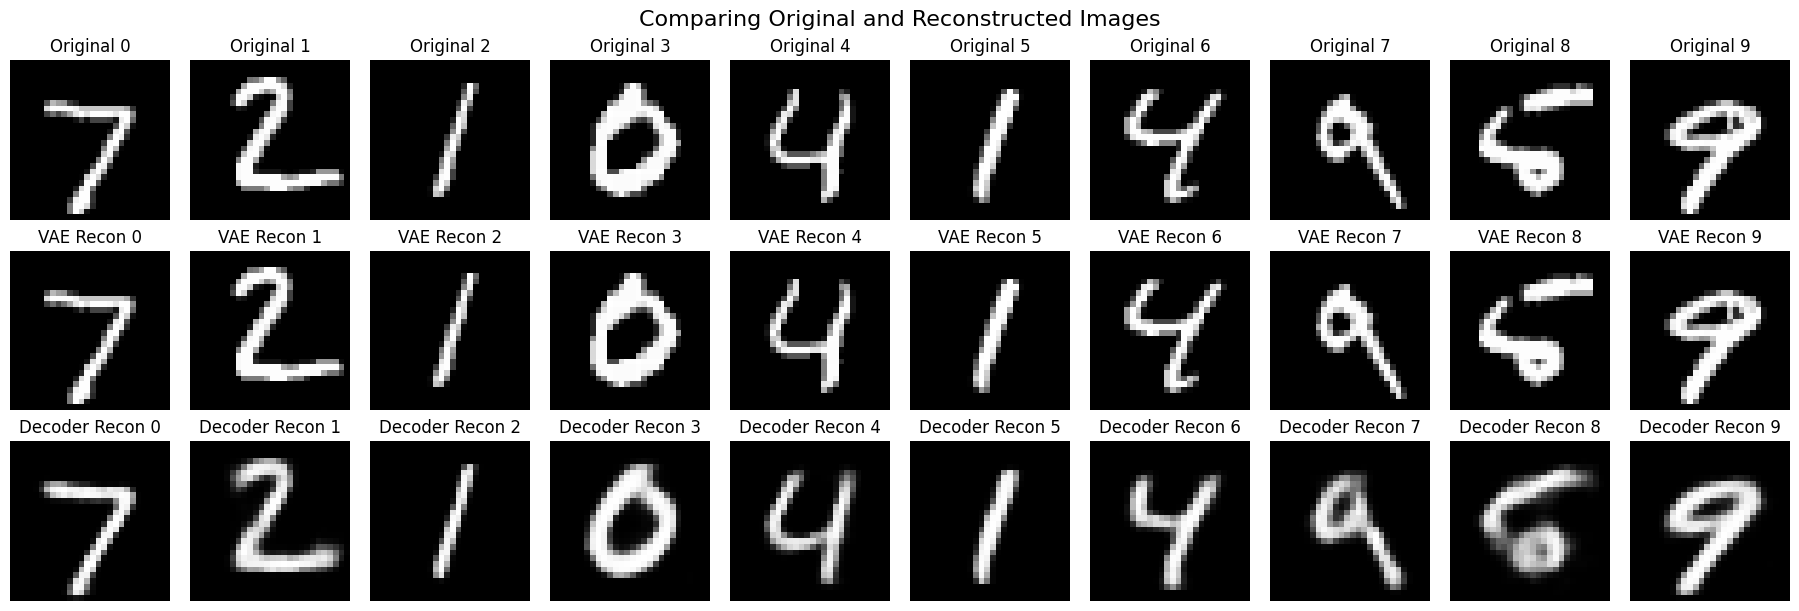

In [54]:
# Extract mu, sigma, and z from the encoder
mu, sigma, z = encoder_model.predict(x_test)

# Reconstruct images using the decoder model
reconstructed_images = decoder_model.predict(z)

# Visualization of original and reconstructed images
num_digits = 10
fig, axes = plt.subplots(3, num_digits, figsize=(18, 6), constrained_layout=True)

for i in range(num_digits):
    # Display original image
    ax = axes[0, i]
    original_img = x_test[i].reshape(28, 28)
    ax.imshow(original_img, cmap='gray')
    ax.axis('off')
    ax.set_title(f"Original {i}")

    # Display reconstruction from VAE (full model)
    ax = axes[1, i]
    reconstructed_img_vae = final_vae_model.predict(x_test[i].reshape(1, 28, 28, 1))
    ax.imshow(reconstructed_img_vae.reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(f"VAE Recon {i}")

    # Display reconstruction from Decoder model only
    ax = axes[2, i]
    reconstructed_img_decoder = decoder_model.predict(z[i].reshape(1, latent_space_dim))
    ax.imshow(reconstructed_img_decoder.reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Decoder Recon {i}")

plt.suptitle("Comparing Original and Reconstructed Images", fontsize=16)
plt.show()

### Training and Validation Losses

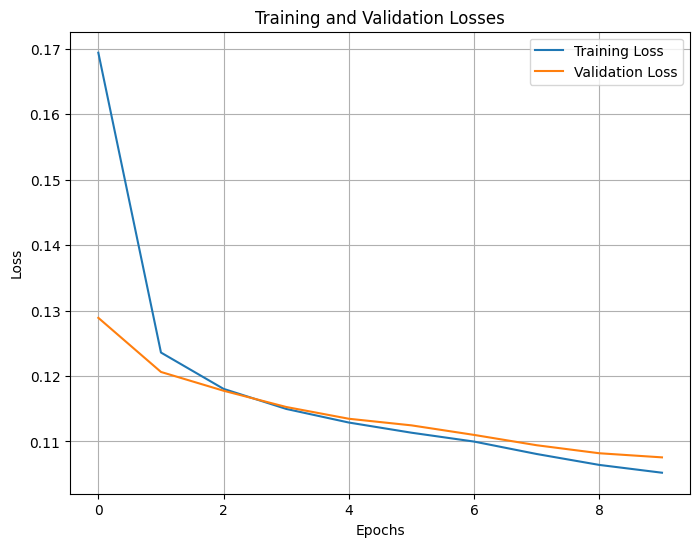

In [55]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### Latent Space Visualization with t-SNE

t-SNE (t-distributed Stochastic Neighbor Embedding) is a technique for dimensionality reduction, particularly useful for visualizing high-dimensional data. It's effective in revealing patterns and clusters in datasets like the encoded representations in a VAE's latent space.


313/313 [==============================] - 2s 5ms/step


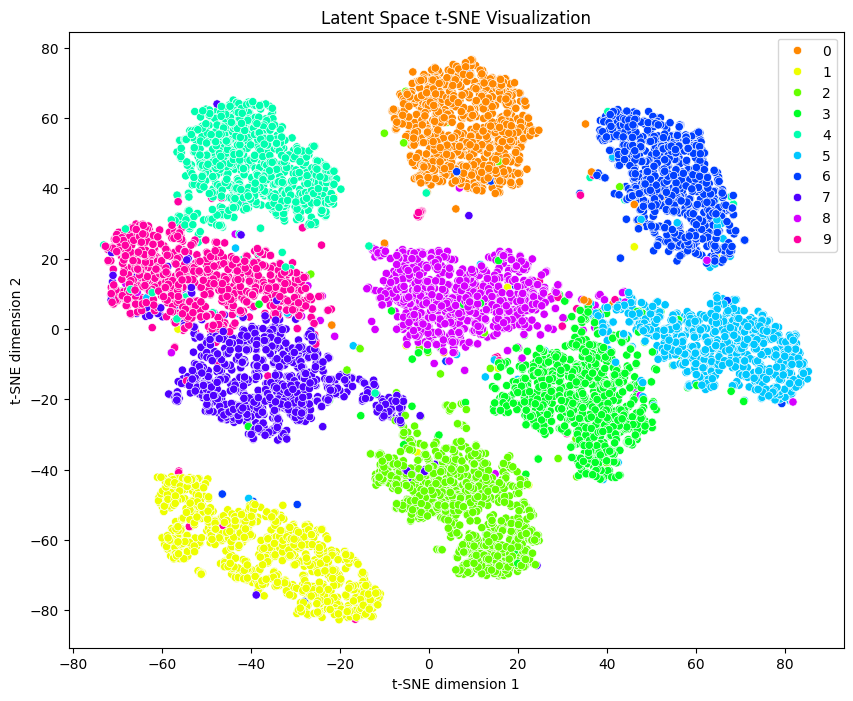

In [60]:
# Obtain latent space representations
_, _, z = encoder_model.predict(x_test, batch_size=32)

# Ensure 'z' is a NumPy array
z = np.array(z)

# Use t-SNE to reduce dimensions to 2D for visualization
z_tsne = TSNE(n_components=2).fit_transform(z)

# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(x=z_tsne[:, 0], y=z_tsne[:, 1], hue=y_test, palette=sns.color_palette("hsv", 10), legend='full')
plt.title("Latent Space t-SNE Visualization")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.show()